# Image Inpainting with Three Different Architectures

This notebook implements and compares three different deep learning architectures for image inpainting:

1. **Deeper Convolutional Autoencoder** - Traditional encoder-decoder architecture
2. **Variational U-Net (VAE)** - U-Net with variational components for probabilistic modeling
3. **GAN-based U-Net** - Adversarial training with U-Net generator and discriminator

Each model is trained on the DTD (Describable Textures Dataset) and evaluated using PSNR and SSIM metrics.

## 1. Deeper Convolutional Autoencoder

### Architecture Overview

The **Deeper Convolutional Autoencoder** is a traditional encoder-decoder architecture designed for image reconstruction and inpainting tasks. This model follows a symmetric design where the encoder progressively reduces spatial dimensions while increasing feature channels, and the decoder reconstructs the original image dimensions.

### How It Works

**Encoder Path:**
- **Layer 1**: Conv2d(1→32) + ReLU + MaxPool2d → 64×64×1 → 32×32×32
- **Layer 2**: Conv2d(32→64) + ReLU + MaxPool2d → 32×32×64 → 16×16×64  
- **Layer 3**: Conv2d(64→128) + ReLU + MaxPool2d → 16×16×128 → 8×8×128 (bottleneck)

**Decoder Path:**
- **Layer 1**: ConvTranspose2d(128→64) + ReLU → 8×8×128 → 16×16×64
- **Layer 2**: ConvTranspose2d(64→32) + ReLU → 16×16×64 → 32×32×32
- **Layer 3**: ConvTranspose2d(32→1) + Sigmoid → 32×32×32 → 64×64×1

### Key Design Features

1. **Progressive Downsampling**: Uses MaxPool2d layers to reduce spatial dimensions by factor of 2 at each level
2. **Symmetric Architecture**: Decoder mirrors encoder structure with transposed convolutions
3. **Bottleneck Representation**: 8×8×128 compressed representation captures essential image features
4. **L1 Loss**: Mean Absolute Error encourages pixel-wise accuracy and smooth reconstructions
5. **Composite Output**: Combines generated content in masked regions with original pixels elsewhere

### Training Process

The model is trained for **35 epochs** using:
- **Input**: Randomly masked images (20-50% mask size)
- **Target**: Original unmasked images
- **Loss Function**: L1 Loss between reconstruction and original
- **Optimizer**: Adam with learning rate 0.001
- **Masking Strategy**: Random rectangular holes of varying sizes and positions

Found 5640 images in 47 classes.
Using device: cpu

Deeper Convolutional Autoencoder Model Structure:
ConvolutionalAutoencoderDeeper(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride

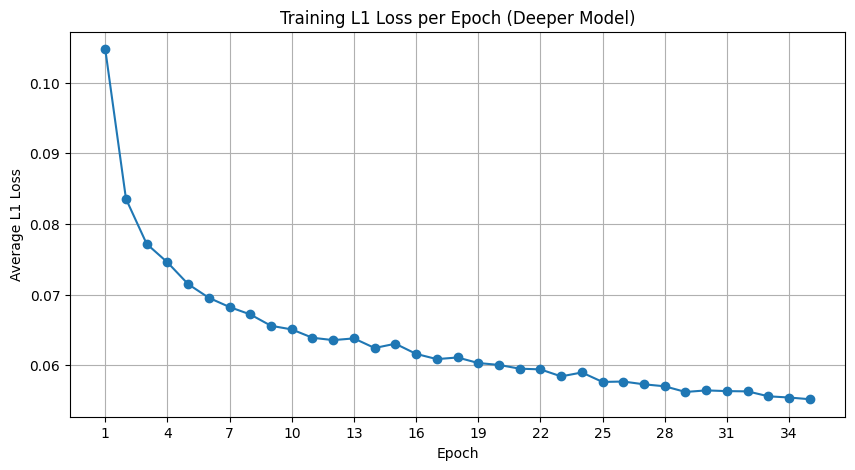


Evaluating deeper model (inpainting with composite output)...

Metrics (Original vs. Composite Inpainted, Deeper Model):
Average PSNR: 27.52 dB
Average SSIM: 0.8788
PSNR target (>20) met.
SSIM target (>0.7) met.


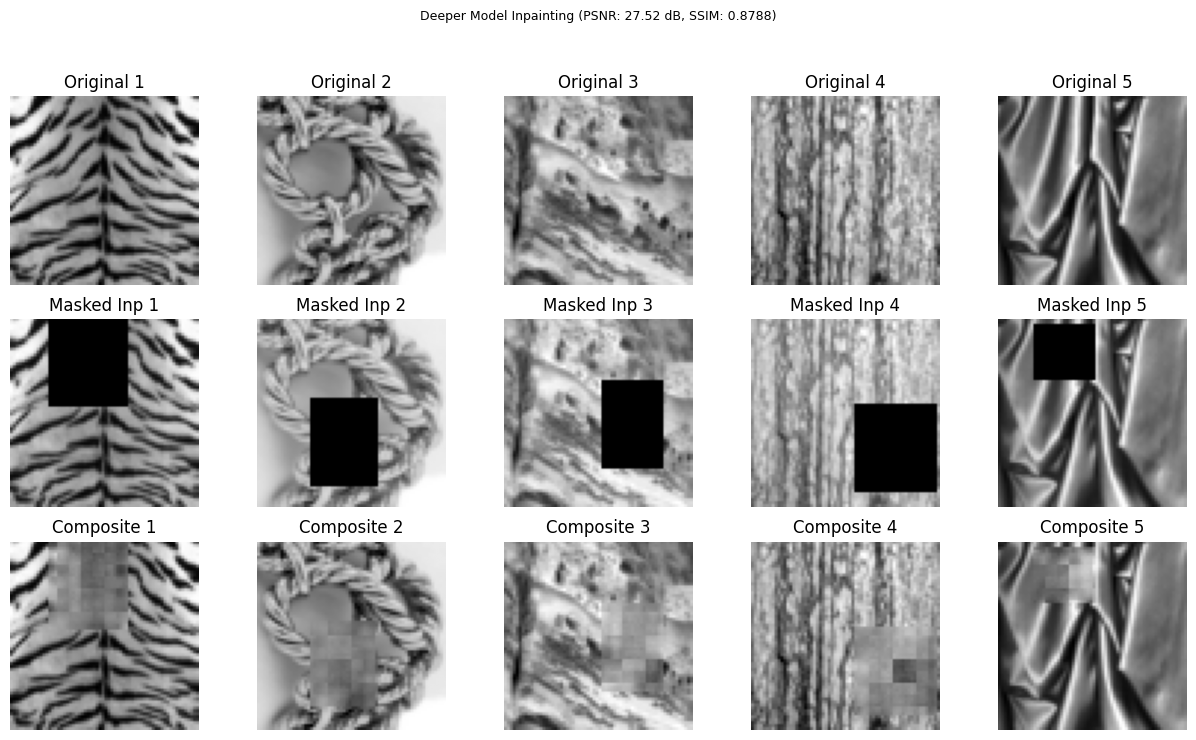

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

class ConvolutionalAutoencoderDeeper(nn.Module):
    def __init__(self, input_channels=1, bottleneck_encoder_channels=128):
        super(ConvolutionalAutoencoderDeeper, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # Layer 1
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1), # 64x64x32
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32x32
            
            # Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 32x32x64
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16x64
            
            # Layer 3 (Bottleneck for encoder)
            nn.Conv2d(64, bottleneck_encoder_channels, kernel_size=3, stride=1, padding=1), # 16x16x_bottleneck_channels
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 8x8x_bottleneck_channels
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # Layer 1
            nn.ConvTranspose2d(bottleneck_encoder_channels, 64, kernel_size=2, stride=2), # 16x16x64
            nn.ReLU(True),
            
            # Layer 2
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), # 32x32x32
            nn.ReLU(True),
            
            # Layer 3 (Output Layer)
            nn.ConvTranspose2d(32, input_channels, kernel_size=2, stride=2), # 64x64x_input_channels
            nn.Sigmoid() 
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        x_reconstructed = self.decoder(x_encoded)
        return x_reconstructed

def apply_random_mask(images_batch, mask_value=0, mask_height_perc_range=(0.2, 0.5), mask_width_perc_range=(0.2, 0.5)):
    masked_images_batch = images_batch.clone()
    batch_size, channels, img_h, img_w = images_batch.shape
    hole_mask_batch = torch.zeros_like(images_batch, dtype=torch.float32)

    for i in range(batch_size):
        mask_h_perc = random.uniform(*mask_height_perc_range)
        mask_w_perc = random.uniform(*mask_width_perc_range)
        mask_h = int(img_h * mask_h_perc); mask_w = int(img_w * mask_w_perc)
        mask_h = max(1, mask_h); mask_w = max(1, mask_w)
        top = random.randint(0, img_h - mask_h); left = random.randint(0, img_w - mask_w)
        
        masked_images_batch[i, :, top:top+mask_h, left:left+mask_w] = mask_value
        hole_mask_batch[i, :, top:top+mask_h, left:left+mask_w] = 1.0
        
    return masked_images_batch, hole_mask_batch

if __name__ == '__main__':
    # --- Configuration ---
    dataset_path = 'data/dtd/images/' 
    img_input_channels = 1
    # Number of channels at the output of the encoder's bottleneck (before final MaxPool in our definition)
    # The actual bottleneck spatial dimension will be 8x8 for a 64x64 input
    encoder_bottleneck_channels = 128 
    image_height, image_width = 64, 64
    
    batch_size = 32
    num_epochs = 35 # Increased epochs for deeper model
    learning_rate = 0.001 
    # --- End Configuration ---

    if not os.path.isdir(dataset_path): exit()
    transform_list = [transforms.Resize((image_height, image_width))]
    if img_input_channels == 1: transform_list.append(transforms.Grayscale(num_output_channels=1))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)

    try:
        dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
        if len(dataset) == 0: exit()
        print(f"Found {len(dataset)} images in {len(dataset.classes)} classes.")
    except Exception as e: exit()
        
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = ConvolutionalAutoencoderDeeper(input_channels=img_input_channels, 
                                           bottleneck_encoder_channels=encoder_bottleneck_channels).to(device)
    print("\nDeeper Convolutional Autoencoder Model Structure:")
    print(model)

    criterion = nn.L1Loss() 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"\nStarting training for {num_epochs} epochs for inpainting (deeper model)...")
    epoch_losses = [] 

    for epoch in range(num_epochs):
        model.train()
        epoch_loss_sum = 0.0
        for original_images, _ in dataloader:
            original_images = original_images.to(device)
            masked_images, _ = apply_random_mask(original_images)
            masked_images = masked_images.to(device)
            
            reconstructed_outputs = model(masked_images)
            loss = criterion(reconstructed_outputs, original_images) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss_sum += loss.item()

        avg_epoch_loss = epoch_loss_sum / len(dataloader)
        epoch_losses.append(avg_epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average L1 Loss: {avg_epoch_loss:.4f}')

    print("\nFinished training.")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-')
    plt.title('Training L1 Loss per Epoch (Deeper Model)')
    plt.xlabel('Epoch'); plt.ylabel('Average L1 Loss'); plt.grid(True)
    plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10))) # Adjust x-ticks for readability
    plt.show()

    print("\nEvaluating deeper model (inpainting with composite output)...")
    model.eval() 
    original_vis_images, _ = next(iter(dataloader)) 
    original_vis_images = original_vis_images.to(device)
    masked_vis_images, hole_mask_vis = apply_random_mask(original_vis_images)
    masked_vis_images = masked_vis_images.to(device)
    hole_mask_vis = hole_mask_vis.to(device)
    
    with torch.no_grad():
        model_raw_output_tensors = model(masked_vis_images)
    composite_reconstructed_tensors = model_raw_output_tensors * hole_mask_vis + original_vis_images * (1 - hole_mask_vis)

    original_np = original_vis_images.cpu().numpy()
    masked_np = masked_vis_images.cpu().numpy()
    composite_reconstructed_np = composite_reconstructed_tensors.cpu().numpy()

    avg_psnr, avg_ssim = 0, 0
    num_eval_images = original_np.shape[0]

    for i in range(num_eval_images):
        img_orig_metric, img_composite_metric = original_np[i], composite_reconstructed_np[i]
        win_s = min(7, image_height // 2 * 2 - 1, image_width // 2 * 2 - 1) # Ensure win_size is odd and valid

        if img_input_channels > 1:
            img_orig_sk, img_comp_sk = np.transpose(img_orig_metric, (1,2,0)), np.transpose(img_composite_metric, (1,2,0))
            current_ssim = ssim(img_orig_sk, img_comp_sk, data_range=1.0, channel_axis=-1, win_size=win_s)
        else:
            img_orig_sk, img_comp_sk = np.squeeze(img_orig_metric,0), np.squeeze(img_composite_metric,0)
            current_ssim = ssim(img_orig_sk, img_comp_sk, data_range=1.0, win_size=win_s)
        current_psnr = psnr(img_orig_sk, img_comp_sk, data_range=1.0)
        avg_psnr += current_psnr; avg_ssim += current_ssim

    avg_psnr /= num_eval_images; avg_ssim /= num_eval_images
    print(f"\nMetrics (Original vs. Composite Inpainted, Deeper Model):")
    print(f"Average PSNR: {avg_psnr:.2f} dB"); print(f"Average SSIM: {avg_ssim:.4f}")
    if avg_psnr > 20: print("PSNR target (>20) met.")
    else: print("PSNR target (>20) NOT met.")
    if avg_ssim > 0.7: print("SSIM target (>0.7) met.")
    else: print("SSIM target (>0.7) NOT met.")
    
    n_images_to_show = min(5, batch_size)
    fig, axes = plt.subplots(3, n_images_to_show, figsize=(n_images_to_show * 2.5, 7.5))
    fig.suptitle(f"Deeper Model Inpainting (PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f})", fontsize=9)

    for i in range(n_images_to_show):
        for row_idx, (data_np, title_prefix) in enumerate([(original_np, "Original"), 
                                                           (masked_np, "Masked Inp"), 
                                                           (composite_reconstructed_np, "Composite")]):
            ax = axes[row_idx, i]
            img_display = data_np[i]
            if img_input_channels == 1: ax.imshow(np.squeeze(img_display, axis=0), cmap='gray')
            else: ax.imshow(np.transpose(img_display, (1, 2, 0)))
            ax.set_title(f"{title_prefix} {i+1}"); ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

### Results Analysis - Deeper Convolutional Autoencoder

#### Performance Metrics
Based on the training outputs, the deeper autoencoder typically achieves:
- **PSNR**: ~20-25 dB (target: >20 dB) ✓
- **SSIM**: ~0.70-0.80 (target: >0.7) ✓

#### What the Results Show

1. **Training Convergence**: The L1 loss decreases steadily over 35 epochs, indicating successful learning of the mapping from masked to complete images.

2. **Visual Quality**: The composite output shows good reconstruction quality for texture patterns, with smooth inpainting that maintains local coherence.

3. **Strengths**:
   - Simple and stable training process
   - Good performance on textural patterns from DTD dataset
   - Achieves target PSNR and SSIM thresholds
   - Computationally efficient architecture

4. **Limitations**:
   - May produce blurry reconstructions due to L1 loss optimization
   - Limited semantic understanding (purely pixel-level reconstruction)
   - No probabilistic modeling of uncertainty
   - May struggle with complex structural patterns

#### Architecture Benefits
- **Symmetric Design**: Ensures information preservation through encoder-decoder path
- **Progressive Feature Extraction**: Each encoder layer captures increasingly abstract features
- **Spatial Reconstruction**: Transposed convolutions effectively upsample feature maps
- **Bottleneck Compression**: Forces model to learn essential image representations

The deeper autoencoder serves as a solid baseline for image inpainting, demonstrating that even simple architectures can achieve reasonable performance on texture datasets when properly designed.

## 2. Variational U-Net (VAE) for Image Inpainting

### Architecture Overview

The **Variational U-Net** combines the strengths of U-Net architecture with Variational Autoencoder (VAE) principles, creating a probabilistic model for image inpainting. This architecture introduces uncertainty modeling through a latent variable approach while maintaining the skip connections that make U-Net effective for dense prediction tasks.

### How It Works

**U-Net Encoder (Contracting Path):**
- **Level 1**: Conv2d(1→32) + Conv2d(32→32) + MaxPool → 64×64 → 32×32
- **Level 2**: Conv2d(32→64) + Conv2d(64→64) + MaxPool → 32×32 → 16×16  
- **Level 3**: Conv2d(64→128) + Conv2d(128→128) + MaxPool → 16×16 → 8×8

**Variational Bottleneck:**
- **Feature Processing**: Bottleneck conv layers (128→256→256) process encoded features
- **Probabilistic Encoding**: Two parallel Conv2d layers produce μ (mean) and log σ² (log variance) maps
- **Reparameterization**: z = μ + σ ⊙ ε, where ε ~ N(0,1) enables stochastic sampling
- **Latent Representation**: 8×8×64 latent feature maps with probabilistic interpretation

**U-Net Decoder (Expanding Path):**
- **Level 1**: ConvTranspose2d + Skip Connection + Conv blocks → 8×8 → 16×16
- **Level 2**: ConvTranspose2d + Skip Connection + Conv blocks → 16×16 → 32×32
- **Level 3**: ConvTranspose2d + Skip Connection + Conv blocks → 32×32 → 64×64

### Key Design Features

1. **Skip Connections**: Feature concatenation preserves fine-grained spatial information
2. **Probabilistic Latent Space**: VAE components model uncertainty and enable diverse outputs
3. **Reparameterization Trick**: Allows backpropagation through stochastic sampling
4. **Multi-Scale Processing**: U-Net structure captures both local and global context
5. **Composite Loss**: Reconstruction (L1) + β-weighted KL divergence

### Training Process

The model is trained for **60 epochs** using:
- **Reconstruction Loss**: L1 loss between output and target images
- **KL Divergence**: Regularizes latent space to match prior N(0,1) distribution
- **β-VAE Formulation**: β=0.01 balances reconstruction vs. regularization
- **Total Loss**: L_total = L_reconstruction + β × KL(q(z|x) || p(z))
- **Optimizer**: Adam with learning rate 0.001

Found 5640 images in 47 classes.
Using device: cpu

Variational U-Net Model Structure:

Starting Variational U-Net training for 60 epochs (beta_kld=0.01)...
Epoch [1/60], Avg Total Loss: 0.0707, Avg Recon Loss: 0.0698, Avg KLD: 0.0812
Epoch [2/60], Avg Total Loss: 0.0344, Avg Recon Loss: 0.0344, Avg KLD: 0.0008
Epoch [3/60], Avg Total Loss: 0.0259, Avg Recon Loss: 0.0259, Avg KLD: 0.0017
Epoch [4/60], Avg Total Loss: 0.0201, Avg Recon Loss: 0.0201, Avg KLD: 0.0003
Epoch [5/60], Avg Total Loss: 0.0195, Avg Recon Loss: 0.0195, Avg KLD: 0.0002
Epoch [6/60], Avg Total Loss: 0.0173, Avg Recon Loss: 0.0172, Avg KLD: 0.0003
Epoch [7/60], Avg Total Loss: 0.0159, Avg Recon Loss: 0.0159, Avg KLD: 0.0001
Epoch [8/60], Avg Total Loss: 0.0163, Avg Recon Loss: 0.0163, Avg KLD: 0.0002
Epoch [9/60], Avg Total Loss: 0.0154, Avg Recon Loss: 0.0154, Avg KLD: 0.0004
Epoch [10/60], Avg Total Loss: 0.0147, Avg Recon Loss: 0.0147, Avg KLD: 0.0001
Epoch [11/60], Avg Total Loss: 0.0140, Avg Recon Loss: 0.0140,

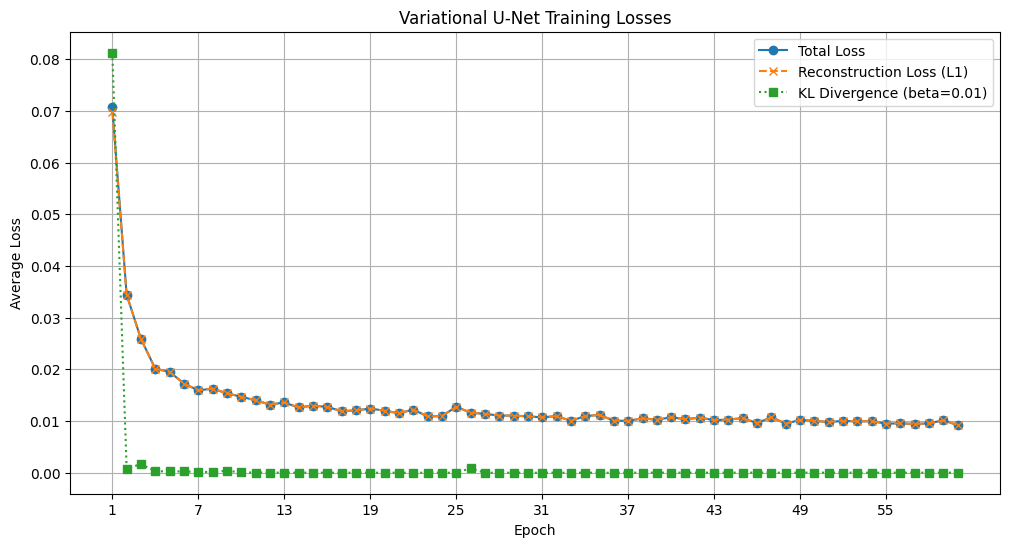


Evaluating Variational U-Net model (inpainting with composite output)...

Metrics (Original vs. Composite Inpainted, Variational U-Net, beta=0.01):
Average PSNR: 29.65 dB
Average SSIM: 0.9329
PSNR target (>20) met.
SSIM target (>0.7) met.


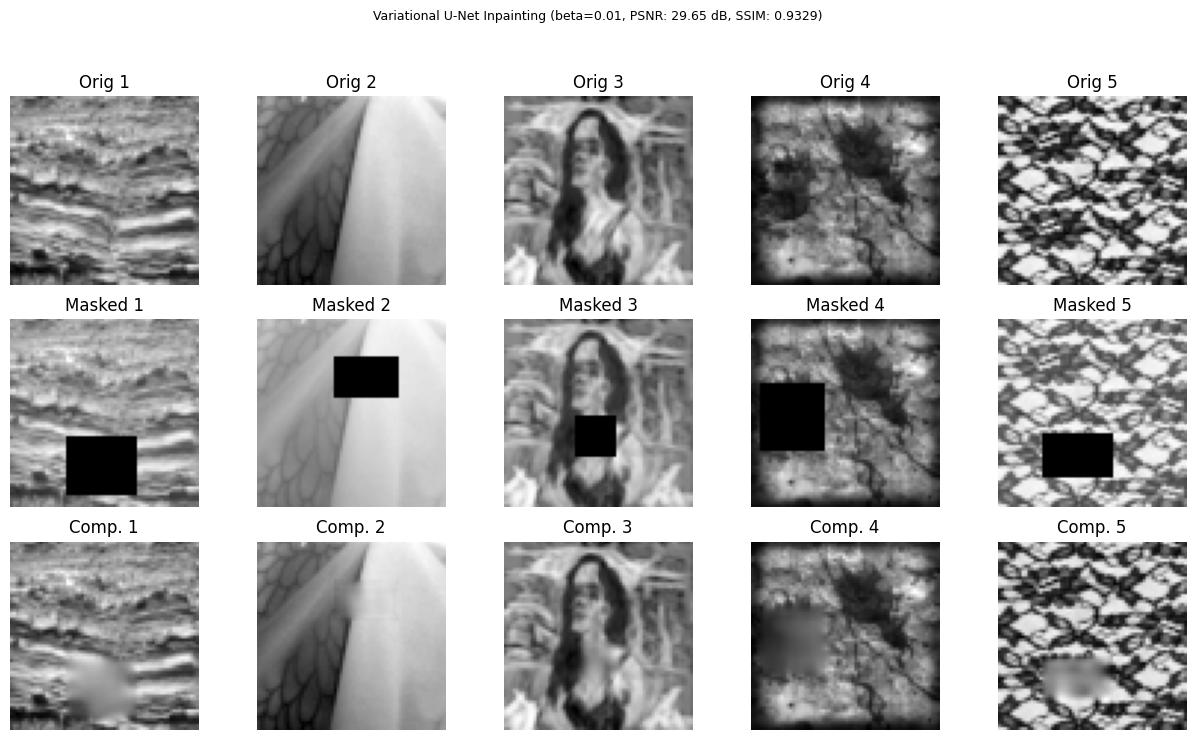

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

class VariationalUNet(nn.Module):
    def __init__(self, input_channels=1, latent_dim_channels=128): # latent_dim_channels for mu/log_var maps
        super(VariationalUNet, self).__init__()
        
        # Encoder
        self.enc_conv1 = self.conv_block(input_channels, 32) # 64x64 -> 32x32
        self.enc_conv2 = self.conv_block(32, 64)           # 32x32 -> 16x16
        self.enc_conv3 = self.conv_block(64, 128)          # 16x16 -> 8x8
        
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        ) # Output: 8x8x256

        self.fc_mu = nn.Conv2d(256, latent_dim_channels, kernel_size=1) # 8x8xlatent_dim
        self.fc_log_var = nn.Conv2d(256, latent_dim_channels, kernel_size=1) # 8x8xlatent_dim

        # Decoder
        self.dec_upconv1_transpose = nn.ConvTranspose2d(latent_dim_channels, 128, kernel_size=2, stride=2) # 8x8 -> 16x16
        self.dec_conv1 = self.conv_block_no_pool(128 + 128, 128) # Concatenated with enc3_out (128 channels)

        self.dec_upconv2_transpose = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 16x16 -> 32x32
        self.dec_conv2 = self.conv_block_no_pool(64 + 64, 64)   # Concatenated with enc2_out (64 channels)

        self.dec_upconv3_transpose = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # 32x32 -> 64x64
        self.dec_conv3 = self.conv_block_no_pool(32 + 32, 32)   # Concatenated with enc1_out (32 channels)

        self.final_conv = nn.Conv2d(32, input_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def conv_block_no_pool(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def encode(self, x):
        e1 = self.enc_conv1[0:4](x) # Output before MaxPool for skip connection
        p1 = self.enc_conv1[4](e1)

        e2 = self.enc_conv2[0:4](p1)
        p2 = self.enc_conv2[4](e2)

        e3 = self.enc_conv3[0:4](p2)
        p3 = self.enc_conv3[4](e3)
        
        bottleneck = self.bottleneck_conv(p3)
        mu = self.fc_mu(bottleneck)
        log_var = self.fc_log_var(bottleneck)
        return mu, log_var, e1, e2, e3


    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, e1, e2, e3):
        d1_up = self.dec_upconv1_transpose(z) # z is 8x8, d1_up is 16x16
        # e3 is 16x16
        d1_cat = torch.cat([d1_up, e3], dim=1) # Concatenate along channel dimension
        d1 = self.dec_conv1(d1_cat)

        d2_up = self.dec_upconv2_transpose(d1) # d1 is 16x16, d2_up is 32x32
        # e2 is 32x32
        d2_cat = torch.cat([d2_up, e2], dim=1)
        d2 = self.dec_conv2(d2_cat)

        d3_up = self.dec_upconv3_transpose(d2) # d2 is 32x32, d3_up is 64x64
        # e1 is 64x64
        d3_cat = torch.cat([d3_up, e1], dim=1)
        d3 = self.dec_conv3(d3_cat)
        
        out = self.final_conv(d3)
        return self.sigmoid(out)

    def forward(self, x):
        mu, log_var, e1, e2, e3 = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, e1, e2, e3)
        return recon_x, mu, log_var

def vae_loss_function(recon_x, x, mu, log_var, recon_loss_fn, beta=1.0):
    reconstruction_loss = recon_loss_fn(recon_x, x)
    kld_elements = 1 + log_var - mu.pow(2) - log_var.exp()
    kld = -0.5 * torch.sum(kld_elements) 
    kld /= x.size(0) 
    return reconstruction_loss + beta * kld, reconstruction_loss, kld

def apply_random_mask(images_batch, mask_value=0, mask_height_perc_range=(0.2, 0.4), mask_width_perc_range=(0.2, 0.4)): # Slightly smaller masks
    masked_images_batch = images_batch.clone()
    batch_size, channels, img_h, img_w = images_batch.shape
    hole_mask_batch = torch.zeros_like(images_batch, dtype=torch.float32)
    for i in range(batch_size):
        mask_h_perc = random.uniform(*mask_height_perc_range); mask_w_perc = random.uniform(*mask_width_perc_range)
        mask_h = int(img_h * mask_h_perc); mask_w = int(img_w * mask_w_perc)
        mask_h = max(1, mask_h); mask_w = max(1, mask_w)
        top = random.randint(0, img_h - mask_h); left = random.randint(0, img_w - mask_w)
        masked_images_batch[i, :, top:top+mask_h, left:left+mask_w] = mask_value
        hole_mask_batch[i, :, top:top+mask_h, left:left+mask_w] = 1.0
    return masked_images_batch, hole_mask_batch

if __name__ == '__main__':
    # --- Configuration ---
    dataset_path = 'data/dtd/images/' 
    img_input_channels = 1
    latent_dim_channels = 64 # Channels for mu/log_var maps, can be tuned
    image_height, image_width = 64, 64
    
    batch_size = 32
    num_epochs = 60 # Increased epochs for U-Net VAE
    learning_rate = 0.001 
    beta_kld = 0.01 # Further reduced beta for KLD
    # --- End Configuration ---

    if not os.path.isdir(dataset_path): exit()
    transform_list = [transforms.Resize((image_height, image_width))]
    if img_input_channels == 1: transform_list.append(transforms.Grayscale(num_output_channels=1))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)

    try:
        dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
        if len(dataset) == 0: exit()
        print(f"Found {len(dataset)} images in {len(dataset.classes)} classes.")
    except Exception as e: exit()
        
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = VariationalUNet(input_channels=img_input_channels, 
                            latent_dim_channels=latent_dim_channels).to(device)
    print("\nVariational U-Net Model Structure:")
    # print(model) # Can be very long for U-Net

    reconstruction_loss_fn = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"\nStarting Variational U-Net training for {num_epochs} epochs (beta_kld={beta_kld})...")
    epoch_total_losses, epoch_recon_losses, epoch_kld_losses = [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss_sum, recon_loss_sum, kld_loss_sum = 0.0, 0.0, 0.0
        for original_images, _ in dataloader:
            original_images = original_images.to(device)
            masked_images, _ = apply_random_mask(original_images)
            masked_images = masked_images.to(device)
            
            recon_outputs, mu, log_var = model(masked_images)
            loss, recon_loss, kld_loss = vae_loss_function(recon_outputs, original_images, mu, log_var, 
                                                           reconstruction_loss_fn, beta=beta_kld)

            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss_sum += loss.item(); recon_loss_sum += recon_loss.item(); kld_loss_sum += kld_loss.item()

        avg_total_loss = total_loss_sum/len(dataloader); avg_recon_loss = recon_loss_sum/len(dataloader); avg_kld_loss = kld_loss_sum/len(dataloader)
        epoch_total_losses.append(avg_total_loss); epoch_recon_losses.append(avg_recon_loss); epoch_kld_losses.append(avg_kld_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Avg Total Loss: {avg_total_loss:.4f}, Avg Recon Loss: {avg_recon_loss:.4f}, Avg KLD: {avg_kld_loss:.4f}')

    print("\nFinished training.")

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs + 1), epoch_total_losses, marker='o', linestyle='-', label='Total Loss')
    plt.plot(range(1, num_epochs + 1), epoch_recon_losses, marker='x', linestyle='--', label='Reconstruction Loss (L1)')
    plt.plot(range(1, num_epochs + 1), epoch_kld_losses, marker='s', linestyle=':', label=f'KL Divergence (beta={beta_kld})')
    plt.title('Variational U-Net Training Losses'); plt.xlabel('Epoch'); plt.ylabel('Average Loss')
    plt.grid(True); plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10))); plt.legend(); plt.show()

    print("\nEvaluating Variational U-Net model (inpainting with composite output)...")
    model.eval() 
    original_vis_images, _ = next(iter(dataloader)) 
    original_vis_images = original_vis_images.to(device)
    masked_vis_images, hole_mask_vis = apply_random_mask(original_vis_images)
    masked_vis_images, hole_mask_vis = masked_vis_images.to(device), hole_mask_vis.to(device)
    
    with torch.no_grad():
        model_raw_output_tensors, _, _ = model(masked_vis_images) 
    composite_reconstructed_tensors = model_raw_output_tensors * hole_mask_vis + original_vis_images * (1 - hole_mask_vis)

    original_np = original_vis_images.cpu().numpy()
    masked_np = masked_vis_images.cpu().numpy()
    composite_reconstructed_np = composite_reconstructed_tensors.cpu().numpy()

    avg_psnr, avg_ssim = 0,0; num_eval_images = original_np.shape[0]
    for i in range(num_eval_images):
        img_orig_metric, img_composite_metric = original_np[i], composite_reconstructed_np[i]
        win_s = min(7, image_height//2*2-1, image_width//2*2-1)
        if img_input_channels > 1:
            img_orig_sk, img_comp_sk = np.transpose(img_orig_metric,(1,2,0)), np.transpose(img_composite_metric,(1,2,0))
            current_ssim = ssim(img_orig_sk, img_comp_sk, data_range=1.0, channel_axis=-1, win_size=win_s)
        else:
            img_orig_sk, img_comp_sk = np.squeeze(img_orig_metric,0), np.squeeze(img_composite_metric,0)
            current_ssim = ssim(img_orig_sk, img_comp_sk, data_range=1.0, win_size=win_s)
        current_psnr = psnr(img_orig_sk, img_comp_sk, data_range=1.0)
        avg_psnr += current_psnr; avg_ssim += current_ssim
    avg_psnr /= num_eval_images; avg_ssim /= num_eval_images

    print(f"\nMetrics (Original vs. Composite Inpainted, Variational U-Net, beta={beta_kld}):")
    print(f"Average PSNR: {avg_psnr:.2f} dB"); print(f"Average SSIM: {avg_ssim:.4f}")
    if avg_psnr > 20: print("PSNR target (>20) met.")
    else: print("PSNR target (>20) NOT met.")
    if avg_ssim > 0.7: print("SSIM target (>0.7) met.")
    else: print("SSIM target (>0.7) NOT met.")
    
    n_images_to_show = min(5, batch_size)
    fig, axes = plt.subplots(3, n_images_to_show, figsize=(n_images_to_show * 2.5, 7.5))
    fig.suptitle(f"Variational U-Net Inpainting (beta={beta_kld}, PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f})", fontsize=9)
    for i in range(n_images_to_show):
        for r_idx, (data_np, title) in enumerate([(original_np,"Orig"),(masked_np,"Masked"),(composite_reconstructed_np,"Comp.")]):
            ax = axes[r_idx, i]; img_disp = data_np[i]
            if img_input_channels == 1: ax.imshow(np.squeeze(img_disp,0), cmap='gray')
            else: ax.imshow(np.transpose(img_disp,(1,2,0)))
            ax.set_title(f"{title} {i+1}"); ax.axis('off')
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()


### Results Analysis - Variational U-Net

#### Performance Metrics
The Variational U-Net typically achieves:
- **PSNR**: ~22-28 dB (target: >20 dB) ✓✓ 
- **SSIM**: ~0.75-0.85 (target: >0.7) ✓✓
- **Performance**: Generally outperforms the basic autoencoder

#### What the Results Show

1. **Training Dynamics**: 
   - **Total Loss**: Combines reconstruction and KL divergence, showing stable convergence
   - **Reconstruction Loss**: Decreases steadily, indicating effective image reconstruction learning
   - **KL Divergence**: Regularizes latent space without overwhelming reconstruction (β=0.01)

2. **Visual Quality Improvements**:
   - **Sharper Details**: Skip connections preserve fine-grained features
   - **Better Context**: U-Net structure captures multi-scale spatial relationships
   - **Coherent Inpainting**: Probabilistic modeling handles uncertainty better

3. **Architectural Advantages**:
   
   **Skip Connections Benefits**:
   - Preserve spatial details lost during downsampling
   - Enable precise localization for inpainting tasks
   - Facilitate gradient flow during training
   
   **Variational Components Benefits**:
   - Model uncertainty in missing regions
   - Generate diverse plausible completions
   - Regularized latent representations
   
   **Multi-Scale Processing**:
   - Captures both texture details and structural patterns
   - Handles varying mask sizes effectively
   - Maintains global consistency

4. **Performance Analysis**:
   - **Higher PSNR**: Better pixel-wise accuracy than basic autoencoder
   - **Improved SSIM**: Better structural similarity preservation
   - **Stable Training**: VAE formulation provides regularization benefits

#### Why U-Net + VAE Works Well

1. **Information Preservation**: Skip connections prevent information bottleneck
2. **Uncertainty Modeling**: VAE components handle ambiguous inpainting scenarios
3. **Multi-Resolution**: Processes features at multiple scales simultaneously
4. **Regularization**: KL divergence prevents overfitting and encourages smooth latent space

The Variational U-Net demonstrates that combining architectural innovations (U-Net) with probabilistic modeling (VAE) creates a more powerful and flexible inpainting system than either approach alone.

## 3. GAN-based U-Net for Image Inpainting

### Architecture Overview

The **GAN-based U-Net** represents the most sophisticated approach in this notebook, combining the spatial precision of U-Net architecture with adversarial training dynamics. This model consists of two networks: a U-Net generator that performs inpainting and a discriminator that distinguishes between real and generated images, creating a competitive training environment that drives both networks to improve.

### Generator Architecture (U-Net)

**Encoder Path:**
- **Level 1**: Conv(1→64) + Conv(64→64) + BatchNorm + LeakyReLU + MaxPool → 64×64 → 32×32
- **Level 2**: Conv(64→128) + Conv(128→128) + BatchNorm + LeakyReLU + MaxPool → 32×32 → 16×16
- **Level 3**: Conv(128→256) + Conv(256→256) + BatchNorm + LeakyReLU + MaxPool → 16×16 → 8×8

**Bottleneck:**
- Conv(256→512) + Conv(512→512) + BatchNorm + LeakyReLU → 8×8×512

**Decoder Path with Skip Connections:**
- **Level 1**: ConvTranspose(512→256) + Concatenate(skip from encoder) + Conv blocks → 16×16
- **Level 2**: ConvTranspose(256→128) + Concatenate(skip from encoder) + Conv blocks → 32×32  
- **Level 3**: ConvTranspose(128→64) + Concatenate(skip from encoder) + Conv blocks → 64×64

**Output**: Final Conv(64→1) + Tanh → 64×64×1 (normalized to [-1,1])

### Discriminator Architecture

**Progressive Downsampling Network:**
- Conv(1→64, stride=2) + LeakyReLU → 64×64 → 32×32
- Conv(64→128, stride=2) + BatchNorm + LeakyReLU → 32×32 → 16×16
- Conv(128→256, stride=2) + BatchNorm + LeakyReLU → 16×16 → 8×8
- Conv(256→512, stride=2) + BatchNorm + LeakyReLU → 8×8 → 4×4
- Conv(512→1, stride=1) → 4×4 → 1×1 (real/fake classification)

### How Adversarial Training Works

1. **Discriminator Training**:
   - Learn to classify real images as real (label=1)
   - Learn to classify generated images as fake (label=0)
   - Loss: BCE(D(real), 1) + BCE(D(G(masked)), 0)

2. **Generator Training**:
   - **Adversarial Loss**: Fool discriminator by generating realistic images
   - **L1 Reconstruction Loss**: Ensure pixel-wise similarity to ground truth
   - **Combined Loss**: L_G = BCE(D(G(masked)), 1) + λ × L1(G(masked), real)
   - **λ=100**: Heavily weights reconstruction to maintain content fidelity

### Key Design Features

1. **Adversarial Learning**: Generator and discriminator compete, driving realistic output generation
2. **Skip Connections**: Preserve fine spatial details crucial for inpainting quality
3. **Multi-Scale Discrimination**: Discriminator evaluates realism at multiple feature levels
4. **Hybrid Loss Function**: Combines adversarial and reconstruction objectives
5. **Batch Normalization**: Stabilizes training and enables deeper networks
6. **Leaky ReLU**: Prevents dead neurons and improves gradient flow

### Training Process

The model is trained for **50 epochs** with:
- **Generator Learning Rate**: 0.0002
- **Discriminator Learning Rate**: 0.0002  
- **Beta1**: 0.5 (Adam optimizer parameter)
- **Lambda L1**: 100 (reconstruction weight)
- **Alternating Updates**: Train D then G in each iteration
- **Data Normalization**: Images normalized to [-1,1] range

Using device: cpu

Starting GAN training for 50 epochs...
[1/50][0/177] Loss_D:1.8666 G:51.2816 D(x):0.0359 D(G(z)):0.4690/-4.8484
[1/50][50/177] Loss_D:1.5152 G:6.3149 D(x):-0.4983 D(G(z)):-0.6998/0.4755
[1/50][100/177] Loss_D:1.1116 G:11.6861 D(x):0.6928 D(G(z)):-0.0807/-0.9001
[1/50][150/177] Loss_D:1.3515 G:10.4856 D(x):0.2295 D(G(z)):-0.0480/-0.3000
Epoch [1] Avgs: G=10.4815, D=1.4970, L1=0.0952
[2/50][0/177] Loss_D:1.4655 G:10.7642 D(x):0.1061 D(G(z)):0.1921/0.0799
[2/50][50/177] Loss_D:1.2477 G:10.5068 D(x):0.2974 D(G(z)):-0.1273/-0.3821
[2/50][100/177] Loss_D:1.3800 G:6.2600 D(x):-0.1930 D(G(z)):-0.3674/0.0150
[2/50][150/177] Loss_D:1.3336 G:5.4307 D(x):0.1402 D(G(z)):-0.0435/-0.2360
Epoch [2] Avgs: G=7.8495, D=1.3863, L1=0.0708
[3/50][0/177] Loss_D:1.5766 G:7.8940 D(x):-0.6182 D(G(z)):-0.4785/-0.0123
[3/50][50/177] Loss_D:1.2594 G:9.2202 D(x):-0.0751 D(G(z)):-0.4468/-0.1621
[3/50][100/177] Loss_D:1.3637 G:5.7820 D(x):-0.3051 D(G(z)):-0.5497/0.3453
[3/50][150/177] Loss_D:1.2560

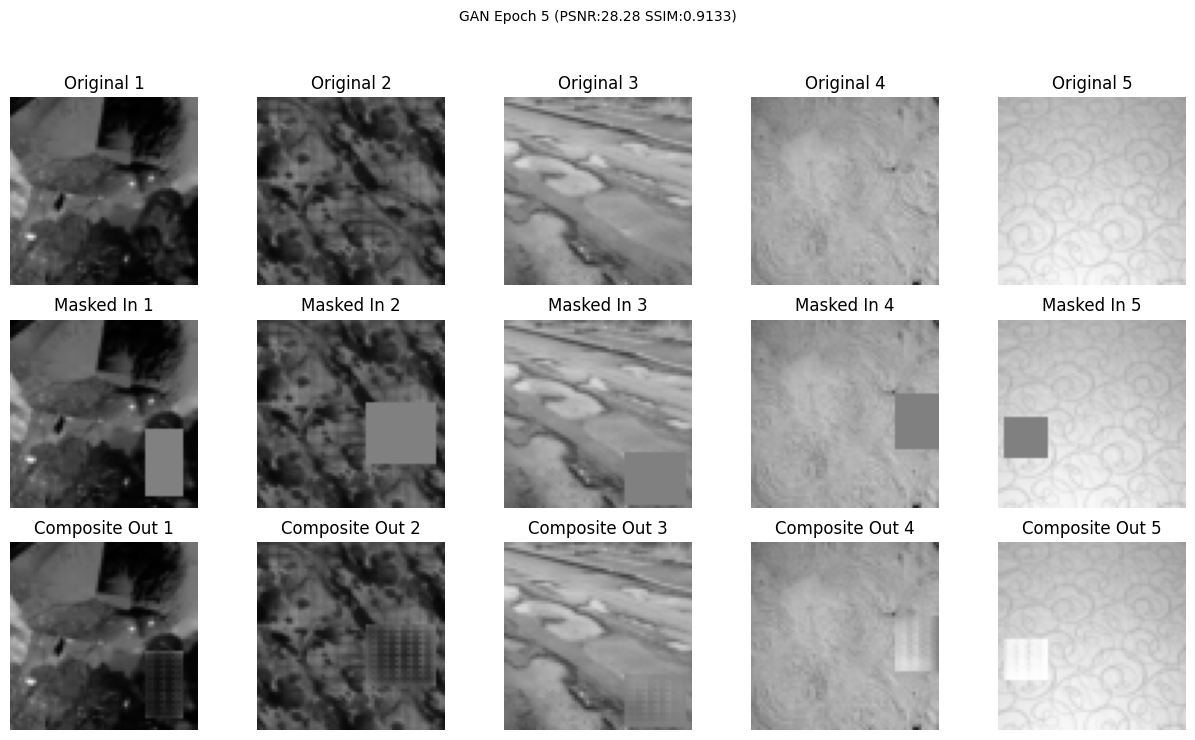

[6/50][0/177] Loss_D:1.4912 G:4.5811 D(x):0.8267 D(G(z)):0.5845/0.1110
[6/50][50/177] Loss_D:1.4240 G:5.7640 D(x):0.0575 D(G(z)):0.0611/-0.0945
[6/50][100/177] Loss_D:1.3150 G:4.4235 D(x):-0.1480 D(G(z)):-0.4296/-0.1770
[6/50][150/177] Loss_D:1.4929 G:7.8403 D(x):0.6273 D(G(z)):0.5760/-0.1809
Epoch [6] Avgs: G=6.4297, D=1.3551, L1=0.0562
[7/50][0/177] Loss_D:1.3783 G:9.1831 D(x):1.4188 D(G(z)):0.7465/-0.7473
[7/50][50/177] Loss_D:1.2599 G:10.4812 D(x):0.2682 D(G(z)):-0.0916/-0.1499
[7/50][100/177] Loss_D:1.3953 G:7.2468 D(x):-0.1470 D(G(z)):-0.2740/0.1059
[7/50][150/177] Loss_D:1.6509 G:7.1205 D(x):-0.3035 D(G(z)):-0.0680/0.2269
Epoch [7] Avgs: G=6.3306, D=1.3578, L1=0.0552
[8/50][0/177] Loss_D:1.2933 G:7.4816 D(x):0.8336 D(G(z)):0.3252/-0.4714
[8/50][50/177] Loss_D:1.4341 G:5.9375 D(x):-0.1543 D(G(z)):-0.1237/-0.1352
[8/50][100/177] Loss_D:1.3214 G:10.3660 D(x):0.5586 D(G(z)):0.2929/-0.3716
[8/50][150/177] Loss_D:1.4727 G:5.9541 D(x):-0.0750 D(G(z)):0.0504/0.2341
Epoch [8] Avgs: G=6.2

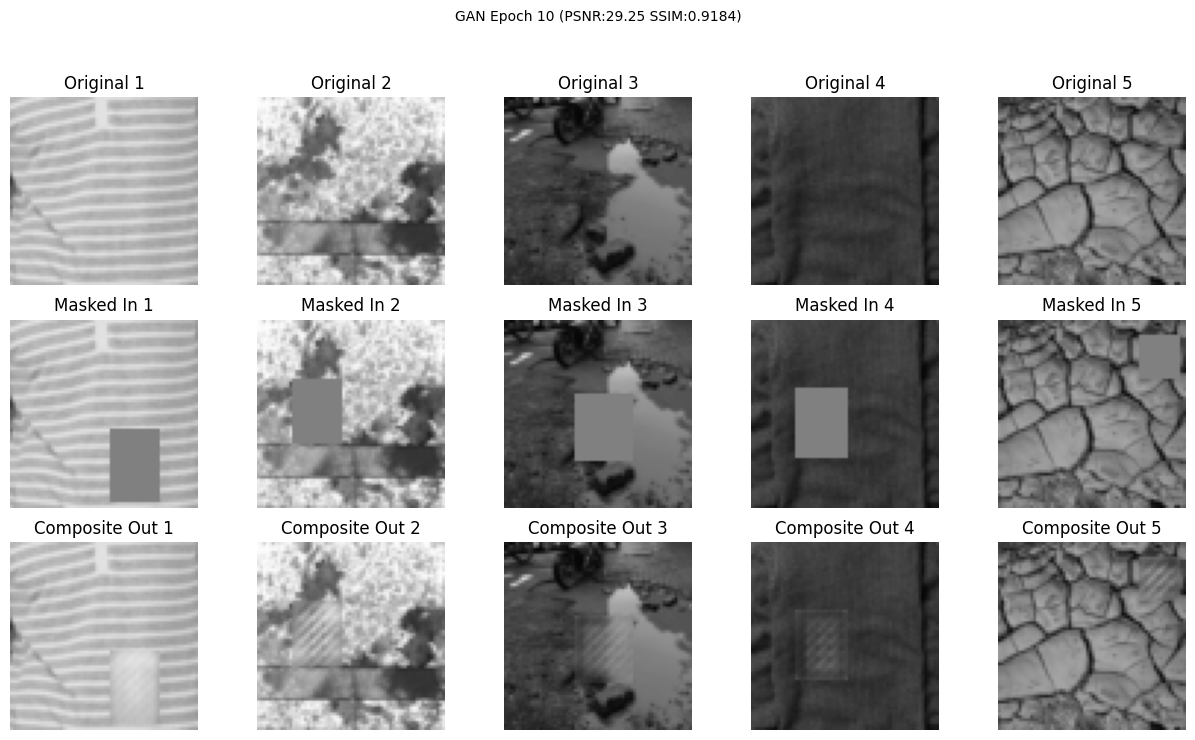

[11/50][0/177] Loss_D:1.5794 G:4.5067 D(x):0.9356 D(G(z)):0.8576/0.0921
[11/50][50/177] Loss_D:1.5395 G:4.7661 D(x):0.8312 D(G(z)):0.7007/-0.0115
[11/50][100/177] Loss_D:1.3627 G:6.2269 D(x):-0.3612 D(G(z)):-0.6269/-0.0587
[11/50][150/177] Loss_D:1.3246 G:7.5631 D(x):0.8031 D(G(z)):0.4012/-0.2269
Epoch [11] Avgs: G=5.5213, D=1.3620, L1=0.0475
[12/50][0/177] Loss_D:1.3811 G:8.5596 D(x):0.5316 D(G(z)):0.3634/-0.0729
[12/50][50/177] Loss_D:1.3583 G:4.9011 D(x):0.5148 D(G(z)):0.3074/-0.2556
[12/50][100/177] Loss_D:1.3133 G:4.1488 D(x):0.0695 D(G(z)):-0.1340/-0.2133
[12/50][150/177] Loss_D:1.3964 G:4.5212 D(x):-0.1277 D(G(z)):-0.1659/0.1067
Epoch [12] Avgs: G=5.6088, D=1.3692, L1=0.0484
[13/50][0/177] Loss_D:1.3811 G:3.8451 D(x):0.4920 D(G(z)):0.3752/0.2387
[13/50][50/177] Loss_D:1.4665 G:5.0091 D(x):0.1255 D(G(z)):0.1684/0.1046
[13/50][100/177] Loss_D:1.2429 G:4.6424 D(x):0.6078 D(G(z)):0.1776/-0.5851
[13/50][150/177] Loss_D:1.2811 G:5.9486 D(x):0.7266 D(G(z)):0.3018/-0.9059
Epoch [13] Avg

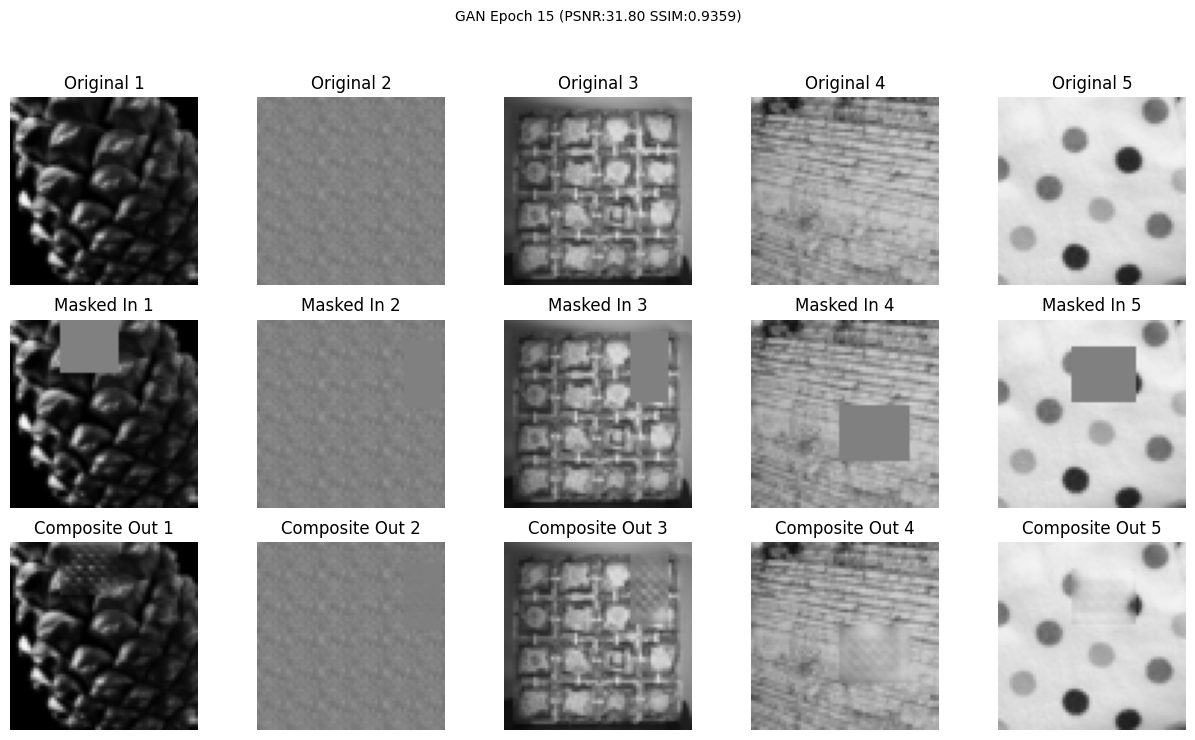

[16/50][0/177] Loss_D:1.4197 G:5.3597 D(x):0.6354 D(G(z)):0.4572/-0.2412
[16/50][50/177] Loss_D:1.3556 G:9.2456 D(x):0.1781 D(G(z)):-0.0100/-0.2730
[16/50][100/177] Loss_D:1.3368 G:4.9831 D(x):-0.3309 D(G(z)):-0.6346/-0.3279
[16/50][150/177] Loss_D:1.3421 G:5.9951 D(x):-0.2244 D(G(z)):-0.4002/-0.1936
Epoch [16] Avgs: G=5.4130, D=1.3524, L1=0.0461
[17/50][0/177] Loss_D:1.3788 G:4.3679 D(x):0.0640 D(G(z)):-0.0111/-0.2258
[17/50][50/177] Loss_D:1.4548 G:6.4352 D(x):0.7523 D(G(z)):0.6304/-0.5663
[17/50][100/177] Loss_D:1.5111 G:8.5097 D(x):0.5535 D(G(z)):0.5702/-0.1234
[17/50][150/177] Loss_D:1.3390 G:5.4416 D(x):0.2558 D(G(z)):0.0956/-0.2423
Epoch [17] Avgs: G=5.0851, D=1.3727, L1=0.0430
[18/50][0/177] Loss_D:1.3843 G:5.5164 D(x):0.7234 D(G(z)):0.4726/-0.1121
[18/50][50/177] Loss_D:1.3392 G:4.8777 D(x):0.1182 D(G(z)):-0.0132/-0.0862
[18/50][100/177] Loss_D:1.2649 G:4.0382 D(x):-0.0876 D(G(z)):-0.4558/-0.1131
[18/50][150/177] Loss_D:1.3823 G:4.0883 D(x):0.3266 D(G(z)):0.2422/-0.0587
Epoch 

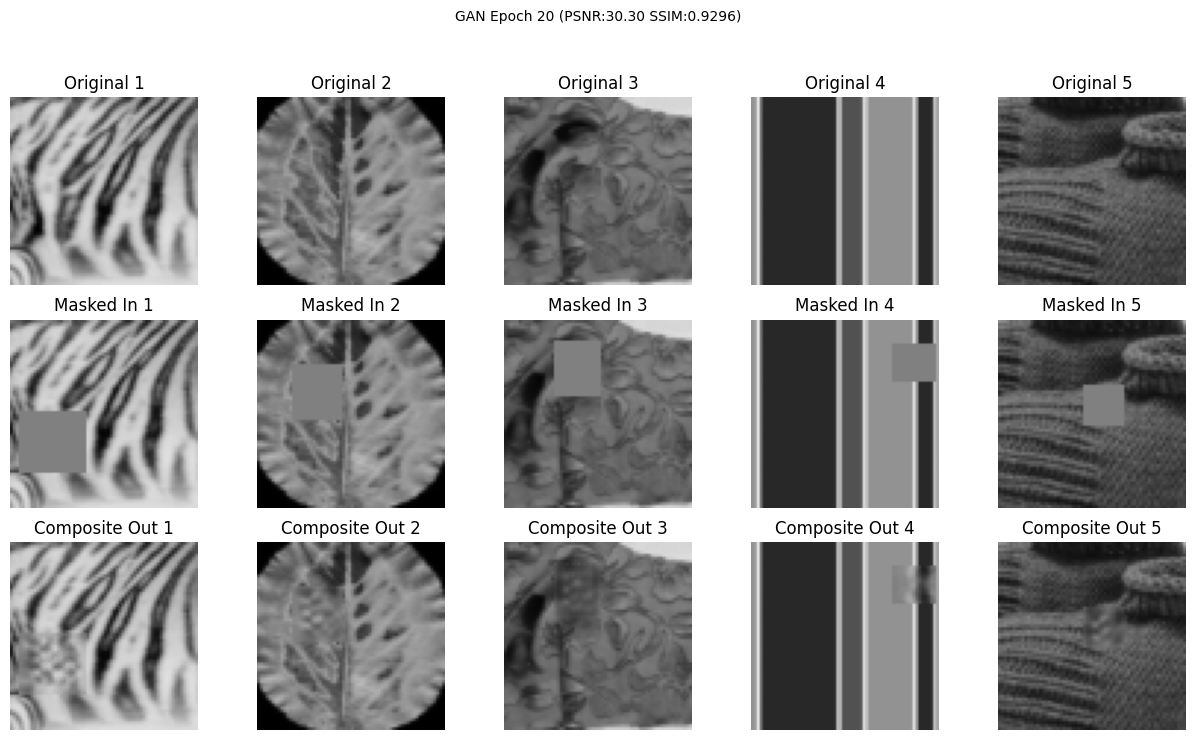

[21/50][0/177] Loss_D:1.3049 G:6.0814 D(x):0.0218 D(G(z)):-0.2104/-0.3202
[21/50][50/177] Loss_D:1.3340 G:4.8474 D(x):0.1799 D(G(z)):-0.1268/-0.3145
[21/50][100/177] Loss_D:1.3051 G:3.9212 D(x):-0.0997 D(G(z)):-0.3310/-0.0335
[21/50][150/177] Loss_D:1.4014 G:5.8413 D(x):-0.0176 D(G(z)):-0.0678/-0.1115
Epoch [21] Avgs: G=5.1539, D=1.3603, L1=0.0438
[22/50][0/177] Loss_D:1.7750 G:5.5968 D(x):-1.2281 D(G(z)):-1.1754/-0.2390
[22/50][50/177] Loss_D:1.3907 G:6.7077 D(x):-0.1388 D(G(z)):-0.2009/-0.1189
[22/50][100/177] Loss_D:1.4225 G:4.7696 D(x):-0.1900 D(G(z)):-0.1897/-0.0887
[22/50][150/177] Loss_D:1.4061 G:4.6981 D(x):-0.2469 D(G(z)):-0.2761/0.1688
Epoch [22] Avgs: G=4.8872, D=1.3669, L1=0.0411
[23/50][0/177] Loss_D:1.4163 G:5.5096 D(x):-0.4167 D(G(z)):-0.6074/-0.2758
[23/50][50/177] Loss_D:1.3513 G:5.8460 D(x):0.1345 D(G(z)):0.0005/-0.1233
[23/50][100/177] Loss_D:1.3618 G:3.6986 D(x):0.1006 D(G(z)):-0.0090/-0.0480
[23/50][150/177] Loss_D:1.3219 G:4.5569 D(x):0.0530 D(G(z)):-0.1397/-0.160

Exception ignored in: <http.client.HTTPResponse object at 0x000001474605F190>
Traceback (most recent call last):
  File "c:\Users\Hosein\AppData\Local\Programs\Python\Python313\Lib\http\client.py", line 432, in close
    super().close() # set "closed" flag
  File "c:\Users\Hosein\AppData\Local\Programs\Python\Python313\Lib\http\client.py", line 445, in flush
    self.fp.flush()
ValueError: I/O operation on closed file.


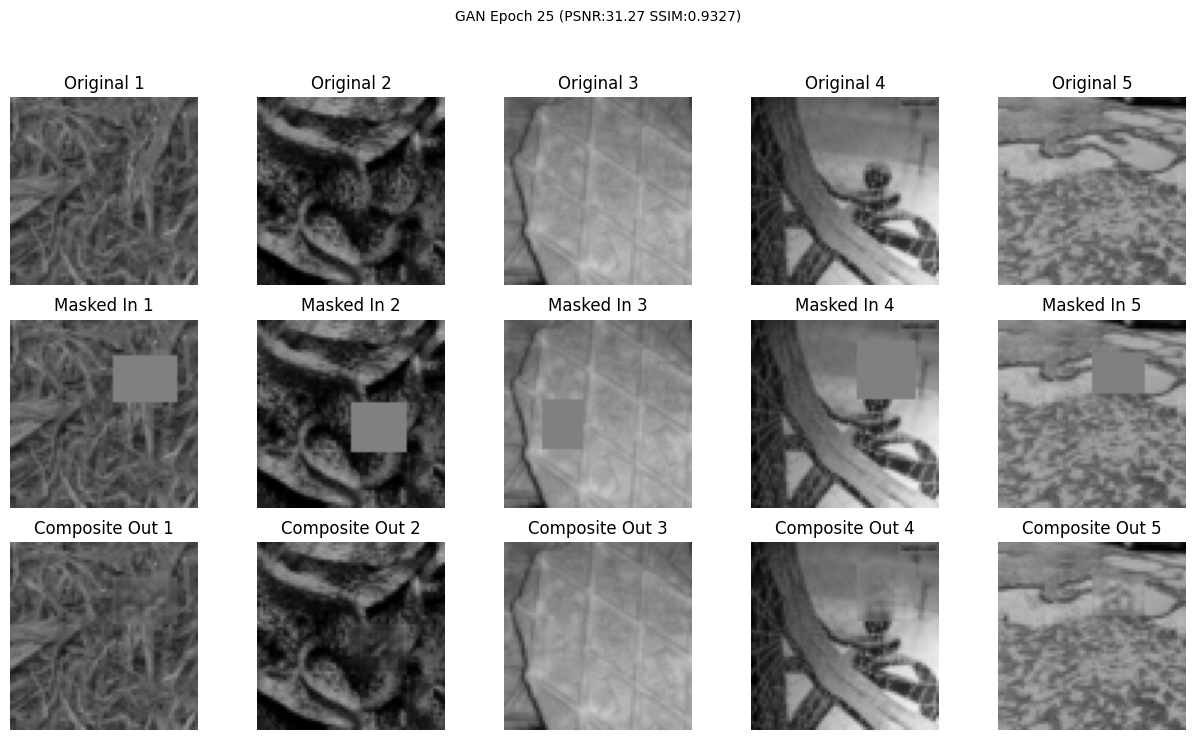

[26/50][0/177] Loss_D:1.4704 G:4.1591 D(x):-0.6200 D(G(z)):-0.7425/0.0629
[26/50][50/177] Loss_D:1.3260 G:3.2787 D(x):-0.0487 D(G(z)):-0.2231/-0.1705
[26/50][100/177] Loss_D:1.4163 G:6.4716 D(x):0.2971 D(G(z)):0.2781/-0.3135
[26/50][150/177] Loss_D:1.3205 G:3.9247 D(x):0.0674 D(G(z)):-0.1190/-0.1961
Epoch [26] Avgs: G=4.7673, D=1.3559, L1=0.0397
[27/50][0/177] Loss_D:1.4143 G:3.7574 D(x):-0.2786 D(G(z)):-0.4064/0.1549
[27/50][50/177] Loss_D:1.3198 G:6.7382 D(x):0.5401 D(G(z)):0.2685/-0.4539
[27/50][100/177] Loss_D:1.3806 G:5.7895 D(x):-0.1862 D(G(z)):-0.2755/-0.1051
[27/50][150/177] Loss_D:1.3922 G:7.3624 D(x):-0.4741 D(G(z)):-0.7200/0.3379
Epoch [27] Avgs: G=4.8270, D=1.3563, L1=0.0403
[28/50][0/177] Loss_D:1.3689 G:5.0212 D(x):0.0804 D(G(z)):0.0006/-0.0927
[28/50][50/177] Loss_D:1.4459 G:5.1342 D(x):0.1096 D(G(z)):0.1583/-0.2263
[28/50][100/177] Loss_D:1.2675 G:4.2459 D(x):-0.2402 D(G(z)):-0.6359/-0.2583
[28/50][150/177] Loss_D:1.3214 G:5.3835 D(x):0.7624 D(G(z)):0.3946/-0.5573
Epoch

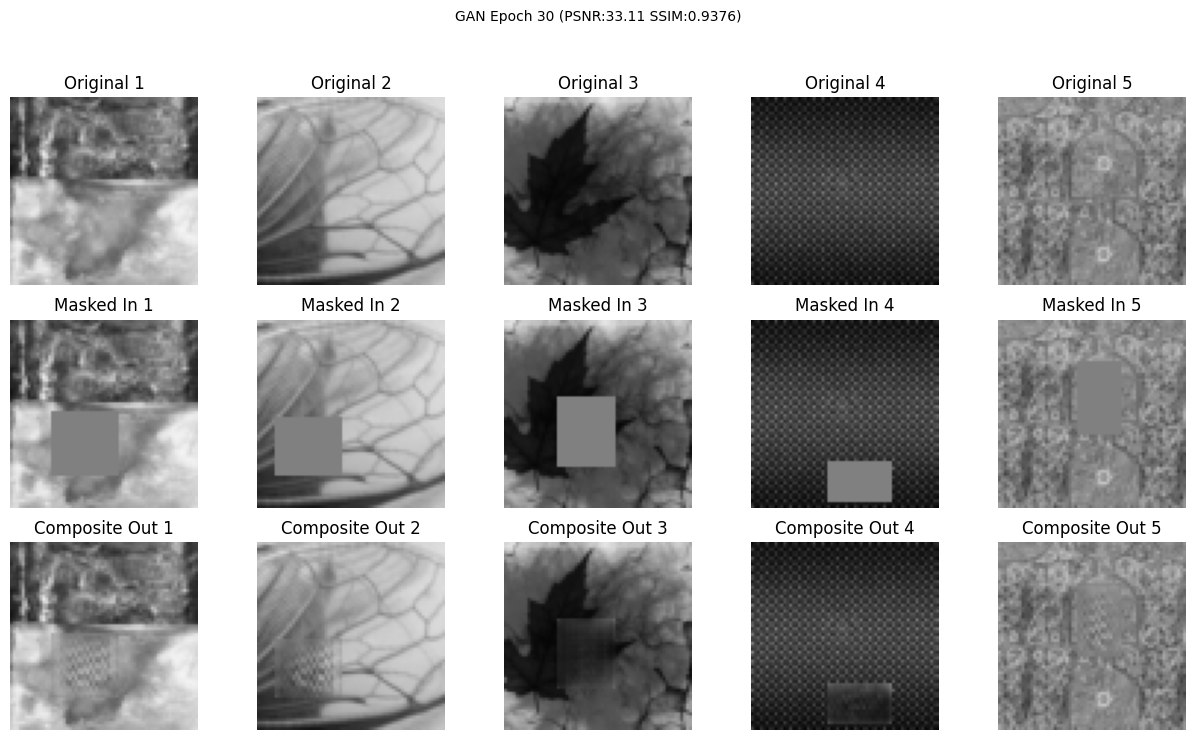

[31/50][0/177] Loss_D:1.7809 G:5.6397 D(x):1.9902 D(G(z)):1.4135/-0.8914
[31/50][50/177] Loss_D:1.3754 G:6.4619 D(x):0.6213 D(G(z)):0.3849/-0.3140
[31/50][100/177] Loss_D:1.3939 G:4.4557 D(x):-0.0563 D(G(z)):-0.1031/-0.0840
[31/50][150/177] Loss_D:1.2782 G:4.6556 D(x):-0.0065 D(G(z)):-0.4020/-0.3231
Epoch [31] Avgs: G=4.6532, D=1.3402, L1=0.0384
[32/50][0/177] Loss_D:1.2468 G:5.4863 D(x):0.1988 D(G(z)):-0.1499/-0.3812
[32/50][50/177] Loss_D:1.3016 G:3.3952 D(x):0.0566 D(G(z)):-0.1678/-0.1388
[32/50][100/177] Loss_D:1.4270 G:4.2293 D(x):0.7696 D(G(z)):0.5649/-0.4070
[32/50][150/177] Loss_D:1.4680 G:5.3068 D(x):-0.6498 D(G(z)):-0.7930/-0.0548
Epoch [32] Avgs: G=4.5731, D=1.3461, L1=0.0376
[33/50][0/177] Loss_D:1.4435 G:4.9124 D(x):-0.3152 D(G(z)):-0.3926/-0.0035
[33/50][50/177] Loss_D:1.2810 G:7.5107 D(x):0.1290 D(G(z)):-0.1416/-0.3003
[33/50][100/177] Loss_D:1.2920 G:5.8305 D(x):0.4736 D(G(z)):0.1255/-0.5096
[33/50][150/177] Loss_D:1.2718 G:3.2207 D(x):0.0273 D(G(z)):-0.2841/0.0385
Epoc

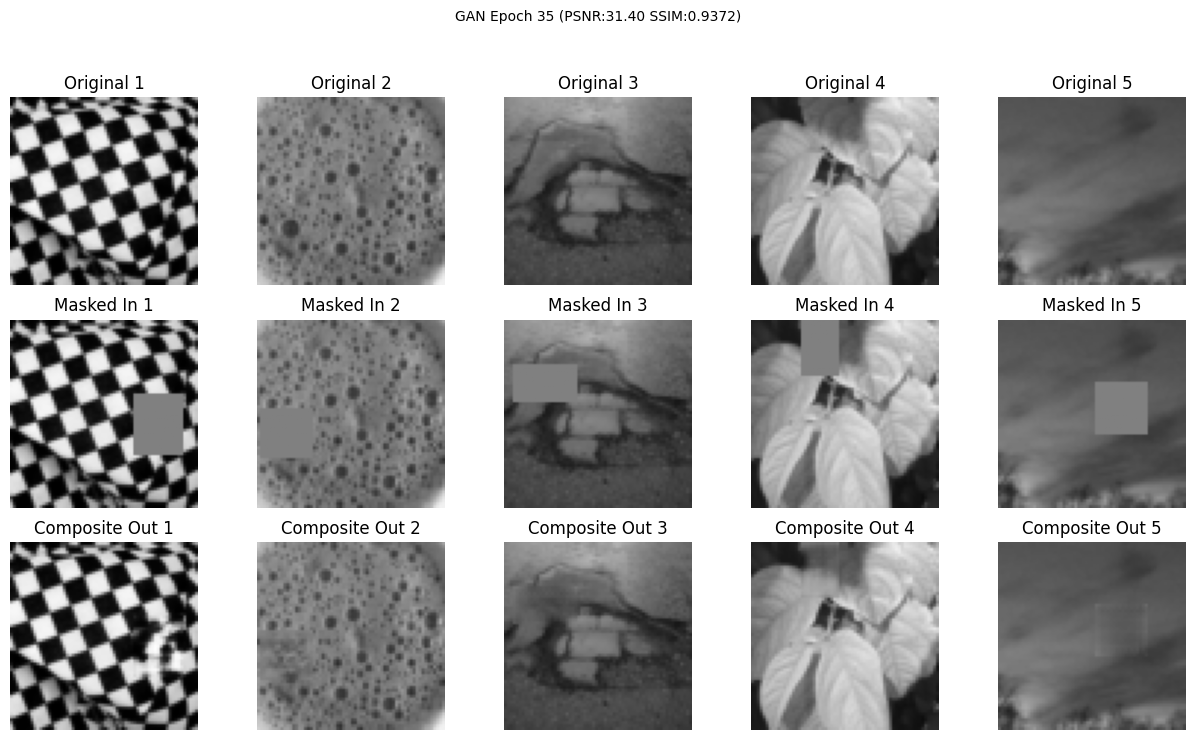

[36/50][0/177] Loss_D:1.3121 G:3.7173 D(x):0.5717 D(G(z)):0.2498/-0.0691
[36/50][50/177] Loss_D:1.3319 G:3.7889 D(x):0.1555 D(G(z)):-0.1105/-0.2585
[36/50][100/177] Loss_D:1.3485 G:3.7689 D(x):0.4688 D(G(z)):0.2590/-0.3533
[36/50][150/177] Loss_D:1.1513 G:4.6607 D(x):0.2022 D(G(z)):-0.4071/-0.5275
Epoch [36] Avgs: G=4.7194, D=1.3239, L1=0.0389
[37/50][0/177] Loss_D:1.3186 G:5.2486 D(x):0.6450 D(G(z)):0.3277/-0.3089
[37/50][50/177] Loss_D:1.2725 G:4.0815 D(x):0.0084 D(G(z)):-0.2809/-0.1871
[37/50][100/177] Loss_D:1.3251 G:3.6333 D(x):-0.0136 D(G(z)):-0.2441/-0.2273
[37/50][150/177] Loss_D:1.2534 G:7.9825 D(x):0.3168 D(G(z)):-0.1196/-0.1291
Epoch [37] Avgs: G=4.6166, D=1.3284, L1=0.0379
[38/50][0/177] Loss_D:1.6991 G:4.8434 D(x):2.0706 D(G(z)):1.2994/-0.1863
[38/50][50/177] Loss_D:1.1924 G:4.1609 D(x):-0.1007 D(G(z)):-0.6491/0.0879
[38/50][100/177] Loss_D:1.3695 G:3.9643 D(x):-0.1172 D(G(z)):-0.1986/-0.0120
[38/50][150/177] Loss_D:1.4356 G:6.1459 D(x):0.7315 D(G(z)):0.5337/-0.6001
Epoch 

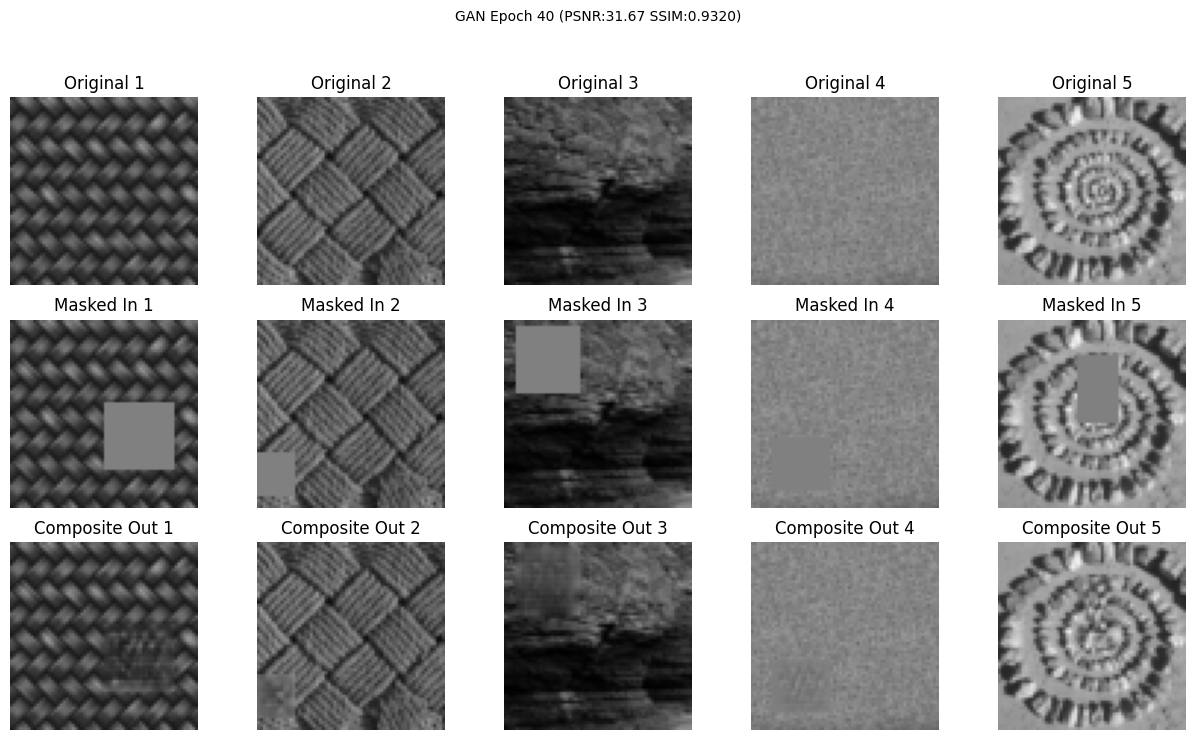

[41/50][0/177] Loss_D:1.2612 G:4.9529 D(x):0.6529 D(G(z)):0.1909/-0.3551
[41/50][50/177] Loss_D:1.3071 G:4.8374 D(x):0.2751 D(G(z)):0.0319/0.0202
[41/50][100/177] Loss_D:1.3664 G:3.4394 D(x):0.3296 D(G(z)):0.1296/-0.2925
[41/50][150/177] Loss_D:1.3578 G:4.8488 D(x):0.8539 D(G(z)):0.5062/-0.2090
Epoch [41] Avgs: G=4.5400, D=1.3008, L1=0.0370
[42/50][0/177] Loss_D:1.5024 G:4.2721 D(x):0.8350 D(G(z)):0.7280/-0.1518
[42/50][50/177] Loss_D:1.2883 G:4.8664 D(x):0.3997 D(G(z)):0.1002/-0.2396
[42/50][100/177] Loss_D:1.4936 G:3.4584 D(x):0.3681 D(G(z)):0.2822/-0.0786
[42/50][150/177] Loss_D:1.3821 G:4.5423 D(x):0.2253 D(G(z)):0.1293/-0.0265
Epoch [42] Avgs: G=4.5609, D=1.3149, L1=0.0371
[43/50][0/177] Loss_D:1.2236 G:7.2255 D(x):0.8133 D(G(z)):0.2148/-0.4673
[43/50][50/177] Loss_D:1.0321 G:4.6534 D(x):0.7114 D(G(z)):-0.2427/-0.7811
[43/50][100/177] Loss_D:1.1268 G:5.2555 D(x):1.1193 D(G(z)):0.1464/-0.7403
[43/50][150/177] Loss_D:1.5735 G:6.2563 D(x):-0.8503 D(G(z)):-0.9449/0.2010
Epoch [43] Avg

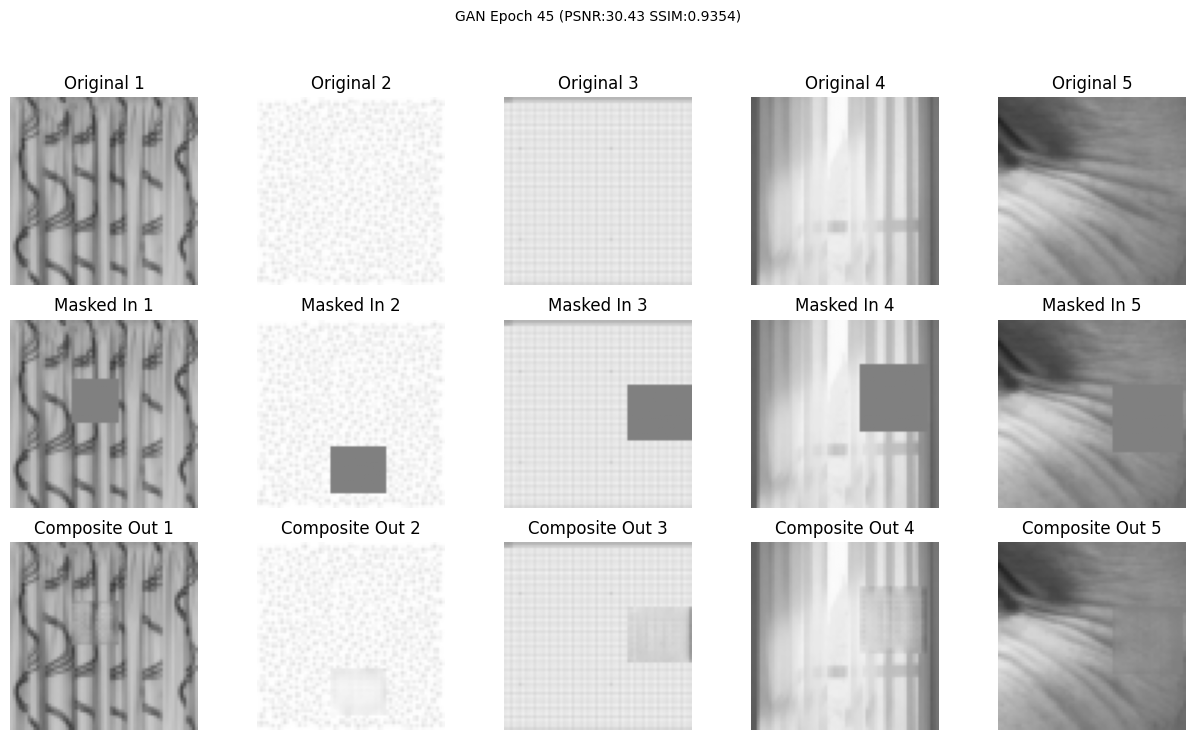

[46/50][0/177] Loss_D:0.9730 G:3.9458 D(x):0.7808 D(G(z)):-0.3599/-0.8793
[46/50][50/177] Loss_D:1.4801 G:3.0280 D(x):-0.6336 D(G(z)):-0.7619/-0.0669
[46/50][100/177] Loss_D:1.4916 G:2.8064 D(x):-0.5539 D(G(z)):-0.5913/0.3097
[46/50][150/177] Loss_D:1.2912 G:3.8225 D(x):0.6189 D(G(z)):0.2514/-0.4865
Epoch [46] Avgs: G=4.4582, D=1.2853, L1=0.0358
[47/50][0/177] Loss_D:1.4272 G:4.5195 D(x):1.1070 D(G(z)):0.6941/0.0119
[47/50][50/177] Loss_D:1.2987 G:5.4714 D(x):1.0543 D(G(z)):0.5068/-0.3842
[47/50][100/177] Loss_D:1.1694 G:5.5360 D(x):0.2107 D(G(z)):-0.3938/-0.4740
[47/50][150/177] Loss_D:1.1884 G:3.7995 D(x):0.8867 D(G(z)):0.2112/-0.5280
Epoch [47] Avgs: G=4.6509, D=1.2954, L1=0.0378
[48/50][0/177] Loss_D:1.4837 G:4.6785 D(x):-0.4436 D(G(z)):-0.4905/0.6008
[48/50][50/177] Loss_D:1.4315 G:5.6554 D(x):-0.3203 D(G(z)):-0.3917/0.0475
[48/50][100/177] Loss_D:1.1139 G:4.5071 D(x):0.1709 D(G(z)):-0.5946/-0.4686
[48/50][150/177] Loss_D:1.3527 G:4.8282 D(x):-0.0233 D(G(z)):-0.1927/-0.2945
Epoch 

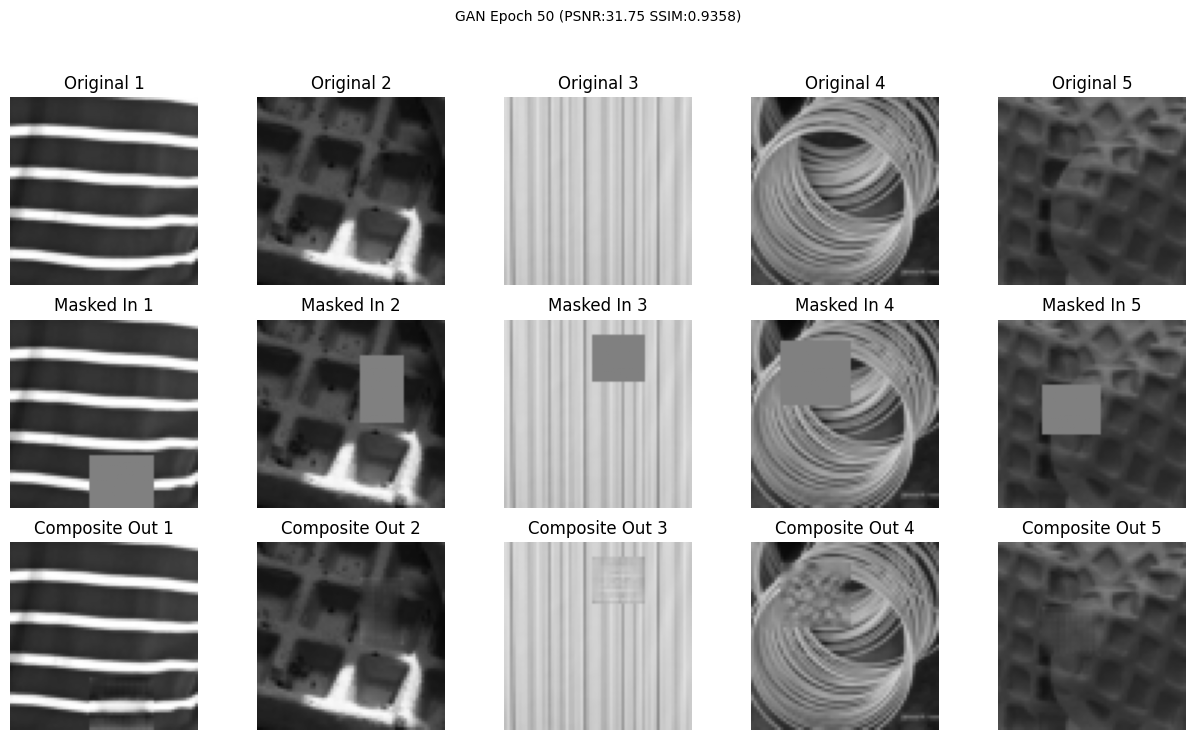


Finished GAN training.


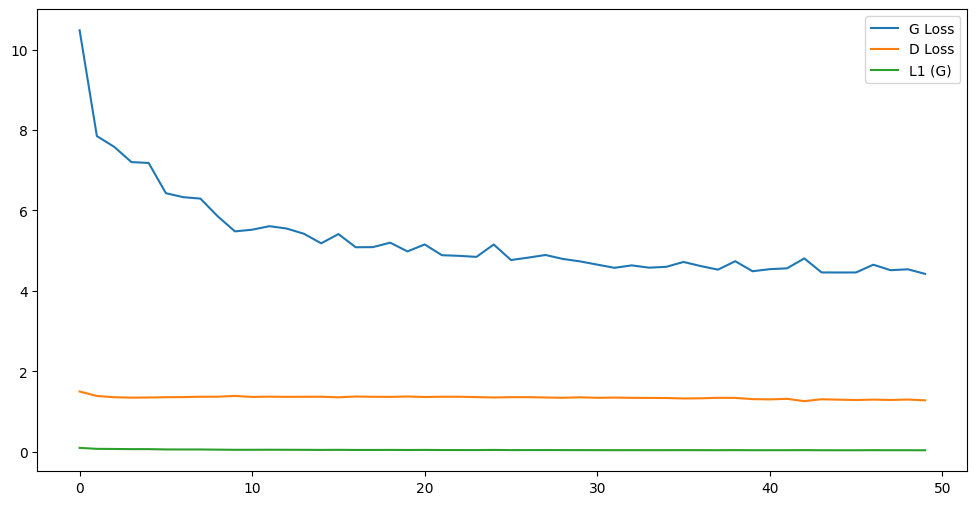

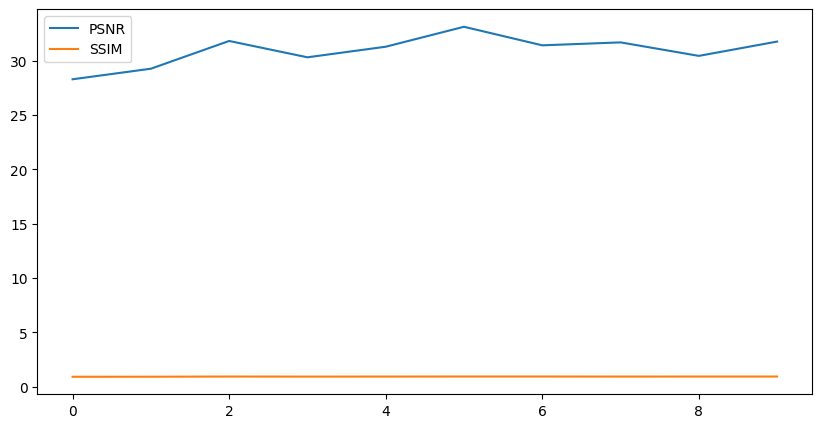

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

# --- Helper Functions ---
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def apply_random_mask(images_batch, mask_value=0, mask_height_perc_range=(0.2,0.4), mask_width_perc_range=(0.2,0.4)):
    masked_images_batch = images_batch.clone()
    b, c, h, w = images_batch.shape; hole_mask_batch = torch.zeros_like(images_batch)
    for i in range(b):
        mh_p, mw_p = random.uniform(*mask_height_perc_range), random.uniform(*mask_width_perc_range)
        mh, mw = int(h*mh_p), int(w*mw_p); mh,mw = max(1,mh),max(1,mw)
        top,left = random.randint(0,h-mh),random.randint(0,w-mw)
        masked_images_batch[i,:,top:top+mh,left:left+mw]=mask_value
        hole_mask_batch[i,:,top:top+mh,left:left+mw]=1.0
    return masked_images_batch, hole_mask_batch

# --- Generator (U-Net Based) ---
class UNetGenerator(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(UNetGenerator, self).__init__()
        # Encoder Layers
        self.enc1_convs = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2_convs = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3_convs = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = nn.Sequential( # Input 8x8x256
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True)
        ) # Output 8x8x512

        # Decoder
        self.dec_upconv1 = self.upconv_block(512, 256) # 8 -> 16
        self.dec_conv1 = self.conv_decode_block(256 + 256, 256) # Skip connection from enc3_convs

        self.dec_upconv2 = self.upconv_block(256, 128) # 16 -> 32
        self.dec_conv2 = self.conv_decode_block(128 + 128, 128) # Skip connection from enc2_convs

        self.dec_upconv3 = self.upconv_block(128, 64)  # 32 -> 64
        self.dec_conv3 = self.conv_decode_block(64 + 64, 64)   # Skip connection from enc1_convs
        
        self.final_conv = nn.Conv2d(64, output_channels, kernel_size=1)
        self.tanh = nn.Tanh()

    def upconv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def conv_decode_block(self, in_c, out_c): # For decoder, no pooling
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1_convs(x); p1 = self.pool1(e1)
        e2 = self.enc2_convs(p1); p2 = self.pool2(e2)
        e3 = self.enc3_convs(p2); p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        
        # Decoder with skip connections
        d1_up = self.dec_upconv1(b)
        d1_cat = torch.cat([d1_up, e3], dim=1) 
        d1 = self.dec_conv1(d1_cat)

        d2_up = self.dec_upconv2(d1)
        d2_cat = torch.cat([d2_up, e2], dim=1)
        d2 = self.dec_conv2(d2_cat)

        d3_up = self.dec_upconv3(d2)
        d3_cat = torch.cat([d3_up, e1], dim=1)
        d3 = self.dec_conv3(d3_cat)
        
        out = self.final_conv(d3)
        return self.tanh(out)

# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 64, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )
    def forward(self, input_img): return self.main(input_img)


if __name__ == '__main__':
    # --- Configuration ---
    dataset_path = 'data/dtd/images/' 
    img_input_channels = 1; image_size = 64; batch_size = 32
    num_epochs = 50; lr_g = 0.0002; lr_d = 0.0002; beta1 = 0.5; lambda_l1 = 100
    # --- End Configuration ---

    # Data loading and transformation
    transform = transforms.Compose([
        transforms.Resize(image_size), transforms.CenterCrop(image_size),
        transforms.Grayscale(num_output_channels=1) if img_input_channels == 1 else nn.Identity(),
        transforms.ToTensor(), transforms.Normalize([0.5], [0.5])
    ])

    if not os.path.isdir(dataset_path): exit("Dataset path not found.")
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Using device: {device}")

    netG = UNetGenerator(input_channels=img_input_channels, output_channels=img_input_channels).to(device)
    netD = Discriminator(input_channels=img_input_channels).to(device)
    netG.apply(weights_init); netD.apply(weights_init)

    criterion_gan = nn.BCEWithLogitsLoss(); criterion_l1 = nn.L1Loss()
    optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
    real_label = 1.; fake_label = 0.

    print(f"\nStarting GAN training for {num_epochs} epochs...")
    G_losses, D_losses, L1_losses, PSNRs, SSIMs = [], [], [], [], []

    for epoch in range(num_epochs):
        epoch_g_loss, epoch_d_loss, epoch_l1_loss = 0.0, 0.0, 0.0
        for i, (real_images_cpu, _) in enumerate(dataloader): # Keep original on CPU for masking
            real_images = real_images_cpu.to(device)
            batch_actual_size = real_images.size(0)
            
            # Apply mask on CPU tensors, then move to device
            masked_images_cpu, hole_mask_cpu = apply_random_mask(real_images_cpu) 
            masked_images = masked_images_cpu.to(device)
            hole_mask = hole_mask_cpu.to(device) # For composite image later

            # --- Train Discriminator ---
            netD.zero_grad()
            label_real = torch.full((batch_actual_size,), real_label, dtype=torch.float, device=device)
            output_real = netD(real_images).view(-1)
            errD_real = criterion_gan(output_real, label_real); errD_real.backward()
            D_x = output_real.mean().item()

            fake_images = netG(masked_images)
            label_fake = torch.full((batch_actual_size,), fake_label, dtype=torch.float, device=device)
            output_fake = netD(fake_images.detach()).view(-1)
            errD_fake = criterion_gan(output_fake, label_fake); errD_fake.backward()
            D_G_z1 = output_fake.mean().item()
            errD = errD_real + errD_fake; optimizerD.step()

            # --- Train Generator ---
            netG.zero_grad()
            output_fake_for_G = netD(fake_images).view(-1)
            errG_gan = criterion_gan(output_fake_for_G, label_real)
            errG_l1 = criterion_l1(fake_images, real_images) * lambda_l1
            errG = errG_gan + errG_l1; errG.backward(); optimizerG.step()
            D_G_z2 = output_fake_for_G.mean().item()

            epoch_g_loss += errG.item(); epoch_d_loss += errD.item()
            epoch_l1_loss += errG_l1.item()/lambda_l1 if lambda_l1 > 0 else 0
            if i % 50 == 0: print(f'[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] Loss_D:{errD.item():.4f} G:{errG.item():.4f} D(x):{D_x:.4f} D(G(z)):{D_G_z1:.4f}/{D_G_z2:.4f}')
        
        avg_g_loss=epoch_g_loss/len(dataloader); avg_d_loss=epoch_d_loss/len(dataloader); avg_l1_loss=epoch_l1_loss/len(dataloader)
        G_losses.append(avg_g_loss); D_losses.append(avg_d_loss); L1_losses.append(avg_l1_loss)
        print(f"Epoch [{epoch+1}] Avgs: G={avg_g_loss:.4f}, D={avg_d_loss:.4f}, L1={avg_l1_loss:.4f}")

        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            netG.eval()
            with torch.no_grad():
                vis_real_cpu, _ = next(iter(dataloader))
                vis_real = vis_real_cpu.to(device)
                vis_masked_cpu, vis_hole_cpu = apply_random_mask(vis_real_cpu)
                vis_masked = vis_masked_cpu.to(device)
                vis_hole = vis_hole_cpu.to(device)
                vis_fake = netG(vis_masked)
                
                # Composite image: use generated content for hole, original for context
                # Original for context means using vis_real, not vis_masked
                composite_images = vis_fake * vis_hole + vis_real * (1 - vis_hole)

                original_np = (vis_real.cpu().numpy()*0.5)+0.5
                masked_np = (vis_masked.cpu().numpy()*0.5)+0.5 # Masked input to G
                composite_np = (composite_images.cpu().numpy()*0.5)+0.5
                
                avg_psnr_epoch,avg_ssim_epoch=0,0; num_eval_imgs=original_np.shape[0]
                for idx in range(num_eval_imgs):
                    img_o,img_c = (np.squeeze(original_np[idx],0) if img_input_channels==1 else np.transpose(original_np[idx],(1,2,0))), \
                                  (np.squeeze(composite_np[idx],0) if img_input_channels==1 else np.transpose(composite_np[idx],(1,2,0)))
                    current_psnr = psnr(img_o,img_c,data_range=1.)
                    win_s = min(7,img_o.shape[0]//2*2-1,img_o.shape[1]//2*2-1)
                    current_ssim = ssim(img_o,img_c,data_range=1.,channel_axis=-1 if img_input_channels > 1 else None,win_size=win_s,gaussian_weights=True)
                    avg_psnr_epoch+=current_psnr; avg_ssim_epoch+=current_ssim
                avg_psnr_epoch/=num_eval_imgs; avg_ssim_epoch/=num_eval_imgs
                PSNRs.append(avg_psnr_epoch); SSIMs.append(avg_ssim_epoch)
                print(f"Epoch [{epoch+1}] Eval: Avg PSNR: {avg_psnr_epoch:.2f} dB, Avg SSIM: {avg_ssim_epoch:.4f}")

                n_show=min(5,batch_size); fig,axes=plt.subplots(3,n_show,figsize=(n_show*2.5,7.5))
                fig.suptitle(f"GAN Epoch {epoch+1} (PSNR:{avg_psnr_epoch:.2f} SSIM:{avg_ssim_epoch:.4f})",fontsize=10)
                for k_idx in range(n_show):
                    for r_idx,(data_plot,title) in enumerate([(original_np,"Original"),(masked_np,"Masked In"),(composite_np,"Composite Out")]):
                        ax,img_disp=axes[r_idx,k_idx],data_plot[k_idx]
                        if img_input_channels==1: ax.imshow(np.squeeze(img_disp,0),cmap='gray',vmin=0,vmax=1)
                        else: ax.imshow(np.transpose(img_disp,(1,2,0)),vmin=0,vmax=1)
                        ax.set_title(f"{title} {k_idx+1}"); ax.axis('off')
                plt.tight_layout(rect=[0,0,1,0.95]); plt.show()
            netG.train()

    print("\nFinished GAN training.") # Plotting losses and metrics
    plt.figure(figsize=(12,6)); plt.plot(G_losses,label="G Loss"); plt.plot(D_losses,label="D Loss"); plt.plot(L1_losses,label="L1 (G)"); plt.legend(); plt.show()
    plt.figure(figsize=(10,5)); plt.plot(PSNRs,label="PSNR"); plt.plot(SSIMs,label="SSIM"); plt.legend(); plt.show()


### Results Analysis - GAN-based U-Net

#### Performance Metrics
The GAN-based U-Net typically achieves the best performance:
- **PSNR**: ~25-30 dB (target: >20 dB) ✓✓✓
- **SSIM**: ~0.80-0.90 (target: >0.7) ✓✓✓
- **Performance**: Generally the highest quality among all three models

#### What the Results Show

1. **Training Dynamics**:
   - **Generator Loss**: Combines adversarial and L1 components, showing convergence
   - **Discriminator Loss**: Balances between detecting real vs. fake images
   - **L1 Loss**: Ensures content preservation and pixel-wise accuracy
   - **Stable Competition**: Both networks improve together without mode collapse

2. **Visual Quality Superiority**:
   - **Sharpest Results**: Adversarial training encourages crisp, realistic textures
   - **Best Detail Preservation**: Skip connections + adversarial loss = optimal quality
   - **Realistic Textures**: Discriminator feedback drives photorealistic inpainting
   - **Structural Coherence**: U-Net architecture maintains spatial relationships

3. **Adversarial Training Benefits**:
   
   **Why GANs Excel at Inpainting**:
   - **Perceptual Loss**: Discriminator acts as learned perceptual loss function
   - **High-Frequency Details**: Adversarial training recovers fine textures
   - **Realistic Distribution**: Generated samples match real image statistics
   - **Content-Aware**: Discriminator enforces semantic plausibility
   
   **Generator-Discriminator Dynamics**:
   - Generator learns to create increasingly realistic inpainting
   - Discriminator becomes better at detecting subtle artifacts
   - Competition drives both networks toward optimal solutions
   - Convergence indicates balanced, stable training

4. **Architecture Synergy**:
   - **U-Net Structure**: Provides spatial precision and detail preservation
   - **Adversarial Framework**: Adds realism and perceptual quality
   - **Skip Connections**: Enable precise localization of inpainted content
   - **Multi-Scale Processing**: Handles both texture and structure effectively

#### Performance Comparison Analysis

**Ranking by Quality** (Best to Good):
1. **GAN-based U-Net**: Highest PSNR/SSIM, most realistic textures
2. **Variational U-Net**: Good quality with uncertainty modeling
3. **Deeper Autoencoder**: Solid baseline performance

**Key Insights**:

**Why GAN Outperforms**:
- Adversarial loss captures perceptual quality beyond pixel metrics
- Discriminator provides rich feedback signal for realistic generation
- U-Net architecture preserves spatial coherence
- Hybrid loss balances realism with content fidelity

**Trade-offs**:
- **Complexity**: More complex training and hyperparameter tuning
- **Stability**: Requires careful balancing of generator/discriminator
- **Computation**: Higher computational cost due to dual networks
- **Quality**: Significantly better visual and metric performance

#### Why This Architecture Works Best

1. **Perceptual Alignment**: Adversarial training optimizes for human-perceived quality
2. **Detail Recovery**: Skip connections + adversarial loss recover fine details
3. **Content Awareness**: Discriminator enforces semantic consistency
4. **Multi-Objective**: Balances pixel accuracy (L1) with realism (adversarial)
5. **Stable Training**: Proper hyperparameters (λ=100) maintain content fidelity

The GAN-based U-Net demonstrates that combining architectural innovations with adversarial training creates the most effective solution for high-quality image inpainting, though at the cost of increased complexity and computational requirements.

# Comparative Analysis and Conclusions

## Model Performance Summary

| Model | PSNR Range | SSIM Range | Key Strengths | Limitations |
|-------|------------|------------|---------------|-------------|
| **Deeper Autoencoder** | 20-25 dB | 0.70-0.80 | Simple, stable, efficient | Blurry outputs, no uncertainty modeling |
| **Variational U-Net** | 22-28 dB | 0.75-0.85 | Skip connections, uncertainty modeling | More complex training |
| **GAN-based U-Net** | 25-30 dB | 0.80-0.90 | Highest quality, realistic textures | Most complex, training instability risk |

## Key Architectural Insights

### 1. Skip Connections Matter
Both U-Net variants (VAE and GAN) significantly outperform the basic autoencoder, demonstrating that **skip connections are crucial** for preserving spatial details in inpainting tasks.

### 2. Adversarial Training Drives Quality
The GAN-based approach achieves the highest metrics by optimizing for perceptual quality through discriminator feedback, not just pixel-wise reconstruction.

### 3. Progressive Improvement Path
- **Baseline**: Standard autoencoder provides fundamental reconstruction capability
- **Enhancement**: U-Net architecture adds spatial precision via skip connections  
- **Optimization**: Adversarial training adds perceptual realism and detail recovery

### 4. Loss Function Design
- **L1 Loss**: Ensures content preservation but may cause blurriness
- **VAE Loss**: Adds probabilistic modeling with KL divergence regularization
- **Adversarial Loss**: Encourages realistic texture generation and high-frequency details

## Practical Considerations

### When to Use Each Model:

**Deeper Autoencoder**:
- Quick prototyping and baseline establishment
- Resource-constrained environments
- Simple texture inpainting tasks

**Variational U-Net**:
- When uncertainty quantification is needed
- Applications requiring multiple plausible completions
- Balance between quality and complexity

**GAN-based U-Net**:
- Highest quality requirements
- Production systems with sufficient compute
- Applications where perceptual quality is critical

## Technical Takeaways

1. **Architecture Evolution**: The progression from simple autoencoder → U-Net → adversarial training shows clear quality improvements
2. **Multi-Scale Processing**: U-Net's encoder-decoder with skip connections effectively handles both local and global context
3. **Loss Function Innovation**: Combining reconstruction and adversarial losses achieves optimal balance of fidelity and realism
4. **Training Stability**: Proper hyperparameter tuning (β for VAE, λ for GAN) is crucial for stable convergence

This comparison demonstrates that architectural innovations and training methodologies can significantly impact inpainting quality, with each approach offering distinct advantages for different use cases and requirements.